In [1]:
from machine_layout import MachineTemplate, BackgroundTemplate, BoundaryError
import numpy as np
import random
import time
from copy import deepcopy
from tqdm import trange

In [2]:
m1 = np.ones([20, 10])
m2 = np.ones([10, 20])
m3 = np.ones([30, 20])
m4 = np.ones([10, 30])

machine1 = MachineTemplate(m1, 'm1', inandoutpos = [[10,0],[20,10]])
machine2 = MachineTemplate(m2, 'm2', inandoutpos = [[10,0],[0,15]])
machine3 = MachineTemplate(m3, 'm3', inandoutpos = [[20,0],[20,20]])
machine4 = MachineTemplate(m4, 'm4', inandoutpos = [[0,20],[10,30]])

ICN = BackgroundTemplate(np.zeros([100, 100]))
ICN.machine_add(machine1)
ICN.machine_add(machine2)
ICN.machine_add(machine3)
ICN.machine_add(machine4)

ICN.product_line("p1", ['m1', 'm2', 'm3', 'm4'])
ICN.product_line("p2", ['m1', 'm2', 'm3'])
ICN.product_line("p3", ['m2', 'm3'])
ICN.product_line("p4", ['m3', 'm4', 'm1'])
machines = ['m1', 'm2', 'm3', 'm4']
h, w = ICN.bg.shape

In [3]:
def factory_random_batch(ICN:BackgroundTemplate):
    random.seed(time.time())
    ICN.reset_bg()
    batch_state = []
    for m_code in machines:
        while True:
            randh = random.randint(0, h-10)
            randw = random.randint(0, w-10)
            try:
                ICN.machine_batch([randh, randw], m_code)
                batch_state.append([randh, randw])
                break
            except BoundaryError as e:
                continue
    return np.array(batch_state).flatten()
    

In [4]:
def factory_batch_loss(ICN: BackgroundTemplate, batch_state, collide_mul = 8):
    ICN.reset_bg()
    machines = ['m1', 'm2', 'm3', 'm4']
    for idx, m_code in enumerate(machines):
        try:
            ICN.machine_batch(batch_state[idx*2:idx*2+2], m_code)
        except BoundaryError as e:
            return np.array(1e4)
    return np.array(ICN.loss(collide_mul=8))

In [24]:
epoch = int(1e2)
best_loss = int(1e3)
best_best_loss = int(1e3)
best_model = None
batch_size = int(1e2)#
best_cases = []

100%: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


In [ ]:
def factory_batch_change2min(factory, batch, steps, collide_mul = 2, batch_change = 100):
    pre_batch = deepcopy(batch)
    def_loss = factory_batch_loss(factory, batch, collide_mul = 2)
    new_loss = def_loss
    
    for i in steps:
        for j in range(batch_change):
            pre_batch = deepcopy(batch)
            for k in range(len(pre_batch)):
                pre_batch[k] += random.randint(-i,i)
            new_loss = factory_batch_loss(factory, pre_batch, collide_mul = 2)
            if new_loss < def_loss:
                batch = deepcopy(pre_batch)
                def_loss = new_loss
    
    return def_loss, batch

def best_cases(batch_size, training_time, factory):
    for i in (pbar := trange(batch_size)):
        best_loss = int(1e3)
        for batch_idx in range(training_time):
            batch = factory_random_batch(factory)
            cost = factory_batch_loss(factory, batch, collide_mul = 2)
            if not batch_idx % (training_time//100):
                pbar.set_description('{0:>2}%'.format(int(batch_idx/training_time*100)+1))
            if best_loss > cost:
                best_batch = deepcopy(batch)
                best_loss = cost
        best_cases.append(best_batch)
    return best_batch
    

In [25]:
new_batch = []
historical_low = 1e3
for k in (pbar := trange(nb_epochs)):
    batch = best_cases[k]
    def_loss, batch = factory_batch_change2min(ICN, batch, steps:= [3,2,1], batch_change:= 100)
    if def_loss < historical_low:
        historical_low = def_loss
        historical_batch = deepcopy(batch)
    new_batch.append(batch)
    

100%|██████████| 100/100 [00:02<00:00, 34.27it/s]


In [22]:
factory_batch_loss(ICN, historical_batch, collide_mul = 2)

array(378.43822416)

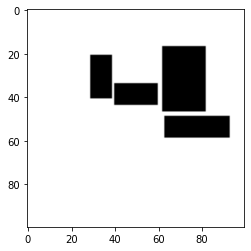

In [28]:
ICN.bg2img()

p1


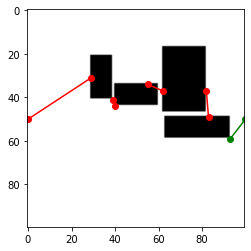

p2


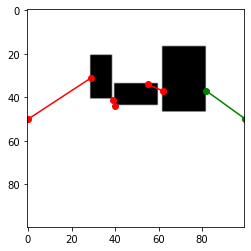

p3


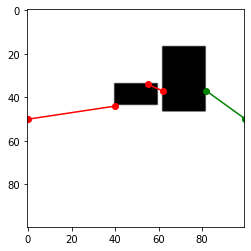

p4


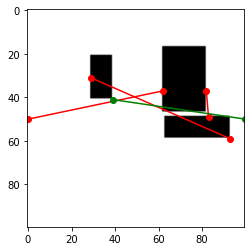

In [29]:
for mcode in ICN.product_machines:
    print(mcode)
    ICN.product_line_img(mcode)